# Intro Task, Object Localization

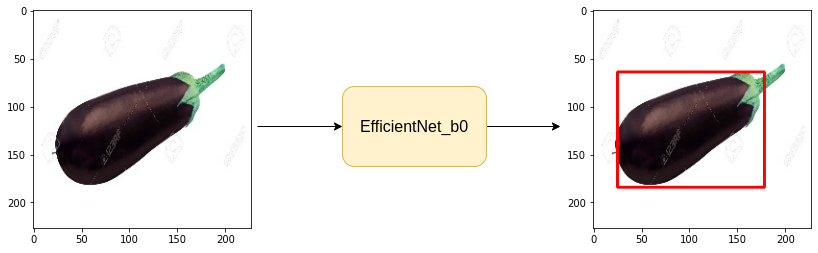

In [ ]:
# install libraries/packages/modules

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-z39jn3t7
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-z39jn3t7
  Resolved https://github.com/albumentations-team/albumentations to commit a4e50e28183a95a8f6dfa2fc4748756876b6ee49
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for albumentations: filename=albumentations-1.4.17-py3-none-any.whl size=225573 sha256=dad31effc046c1eb78debb23223f770993a3b8b2bf8916cec893577a8e4127a4
  Stored in directory: /tmp/pip-ephem-wheel-cache-_lmgbx0p/wheels/51/4d/ab/5aafa8b980086fbc362946de7da4aa3df33aacb3da0da29b93
Successfully built albumentations
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.16
    Uninstalling albucore-0.0.16:
      Successfully uninstalled albucore-0.0.16
  Attempting uninstall: al

In [ ]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (203/203), 2.73 MiB | 6.15 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [ ]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [ ]:
CSV_FILE = '/content/object-localization-dataset/train.csv'
DATA_DIR = '/content/object-localization-dataset'

DEVICE = 'cuda'

BATCH_SIZE = 16
IMG_SIZE = 140

LR = 0.001
EPOCHS = 40
MODEL = 'efficientnet_b0'

NUM_COR = 4

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant


# Understand the dataset

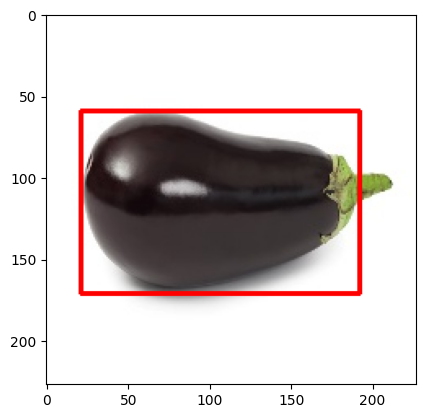

In [ ]:
row = df.iloc[184]

img_path = DATA_DIR + '/' + row.img_path
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pt1 = (row.xmin, row.ymin)
pt2 = (row.xmax, row.ymax)
bnd_box_img = cv2.rectangle(img, pt1, pt2, (255,0,0), 2)
plt.imshow(bnd_box_img)

In [ ]:
train, val = train_test_split(df, test_size=0.2, random_state=42)

# Augmentations

In [ ]:
import albumentations as A

In [ ]:
train_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate()
], bbox_params = A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels']))

valid_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE)
], bbox_params = A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels']))

# Create Custom Dataset

In [ ]:
class ObjLocDataset(torch.utils.data.Dataset):
  def __init__(self, df,augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    xmin = row.xmin
    xmax = row.xmax
    ymin = row.ymin
    ymax = row.ymax

    bbox = [[xmin, ymin, xmax, ymax]]
    img_path = DATA_DIR + '/' + row.img_path

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if self.augmentations:
      data = self.augmentations(image = img, bboxes = bbox, class_labels = [None])
      img = data['image']
      bbox = data['bboxes'][0]

    img = torch.from_numpy(img).permute(2,0,1)/255.0 # (h,w,c)->(c,h,w)
    bbox = torch.tensor(bbox)

    return img, bbox

In [ ]:
trainset = ObjLocDataset(train, train_augs)
validset = ObjLocDataset(val, valid_augs)

In [ ]:
print(f"Total training samples : {len(trainset)}")
print(f"Total validation samples : {len(validset)}")

Total training samples : 148
Total validation samples : 38


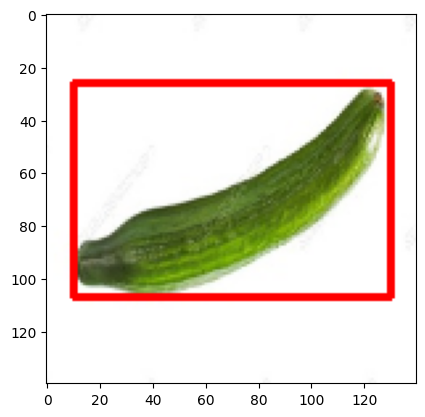

In [ ]:
img, bbox = trainset[6]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Load dataset into batches

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [ ]:
for images, bboxes in trainloader:
  break;


print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [ ]:
from torch import nn
import timm

In [ ]:
class ObjLocModel(nn.Module):
  def __init__(self):
    super(ObjLocModel,self).__init__()
    self.backbone = timm.create_model(model_name=MODEL, pretrained=True, num_classes=4)

  def forward(self, images, gt_bboxes=None):
    bboxes = self.backbone(images)
    if gt_bboxes != None:
      loss = nn.MSELoss()(bboxes, gt_bboxes)
      return bboxes, loss
    return bboxes

In [ ]:
model = ObjLocModel()
model.to(DEVICE);

In [ ]:
random_img = torch.rand(1,3,140,140).to(DEVICE)
model(random_img).shape

torch.Size([1, 4])

# Create Train and Eval Function

In [ ]:
def train_fn(model, dataloader, optimizer):
  total_loss = 0.0
  model.train() # Dropout ON
  for data in tqdm(dataloader):
    images, gt_bboxes = data
    images = images.to(DEVICE)
    gt_bboxes = gt_bboxes.to(DEVICE)


    bboxes, loss = model(images, gt_bboxes)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  return total_loss/len(dataloader)

In [ ]:
def eval_fn(model, dataloader):
  total_loss = 0.0
  model.eval() # Dropout ON
  with torch.no_grad():
    for data in tqdm(dataloader):
      images, gt_bboxes = data
      images = images.to(DEVICE)
      gt_bboxes = gt_bboxes.to(DEVICE)


      bboxes, loss = model(images, gt_bboxes)

      total_loss += loss.item()
  return total_loss/len(dataloader)

#Training Loop

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
best_valid_loss = np.Inf
for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer)
  valid_loss = eval_fn(model, validloader)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("Weights are saved")
    best_valid_loss = valid_loss

  print(f"Epoch : {i+1}")
  print(f"Train Loss : {train_loss}")
  print(f"Valid Loss : {valid_loss}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 1
Train Loss : 5371.069775390625
Valid Loss : 3986.2916666666665


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 2
Train Loss : 1961.1455932617187
Valid Loss : 3183.909912109375


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 3
Train Loss : 1109.3236389160156
Valid Loss : 418.08498128255206


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 4
Train Loss : 697.4615539550781
Valid Loss : 209.90343221028647


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 5
Train Loss : 504.96251525878904
Valid Loss : 266.96873982747394


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 6
Train Loss : 378.96105575561523
Valid Loss : 190.85223388671875


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 7
Train Loss : 290.96937408447263
Valid Loss : 172.2926991780599


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 8
Train Loss : 222.83356323242188
Valid Loss : 159.46520233154297


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 9
Train Loss : 181.82993240356444
Valid Loss : 139.4736124674479


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 10
Train Loss : 136.50215835571288
Valid Loss : 124.45806376139323


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 11
Train Loss : 125.15600967407227
Valid Loss : 156.55232747395834


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 12
Train Loss : 123.84980964660645
Valid Loss : 165.46416727701822


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 13
Train Loss : 111.47266235351563
Valid Loss : 129.6158014933268


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 14
Train Loss : 117.93307189941406
Valid Loss : 131.0245157877604


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 15
Train Loss : 117.0067855834961
Valid Loss : 115.88033040364583


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 16
Train Loss : 102.9919647216797
Valid Loss : 141.0563761393229


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 17
Train Loss : 83.50991134643554
Valid Loss : 107.49063873291016


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 18
Train Loss : 80.6096923828125
Valid Loss : 104.02669779459636


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 19
Train Loss : 67.32843856811523
Valid Loss : 102.64611562093098


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 20
Train Loss : 84.34570922851563
Valid Loss : 75.72557576497395


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 21
Train Loss : 69.83937644958496
Valid Loss : 85.07393391927083


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 22
Train Loss : 56.22410125732422
Valid Loss : 107.98395029703777


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 23
Train Loss : 63.30579261779785
Valid Loss : 90.49433135986328


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 24
Train Loss : 56.63610343933105
Valid Loss : 72.95829264322917


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 25
Train Loss : 52.26481590270996
Valid Loss : 89.65464782714844


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 26
Train Loss : 64.07078971862794
Valid Loss : 82.6238644917806


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 27
Train Loss : 48.16095447540283
Valid Loss : 53.49783833821615


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 28
Train Loss : 50.26760845184326
Valid Loss : 83.29728698730469


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 29
Train Loss : 55.60124168395996
Valid Loss : 56.188655853271484


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 30
Train Loss : 50.440205574035645
Valid Loss : 52.06324895222982


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 31
Train Loss : 46.195034408569335
Valid Loss : 90.09370930989583


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 32
Train Loss : 48.559630393981934
Valid Loss : 83.61179097493489


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 33
Train Loss : 42.34156551361084
Valid Loss : 83.55534108479817


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 34
Train Loss : 39.7146110534668
Valid Loss : 93.05996576944987


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 35
Train Loss : 50.99875011444092
Valid Loss : 70.78465270996094


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 36
Train Loss : 43.1005558013916
Valid Loss : 59.63166046142578


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 37
Train Loss : 43.800096893310545
Valid Loss : 64.11513137817383


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 38
Train Loss : 33.90617504119873
Valid Loss : 63.07711410522461


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 39
Train Loss : 39.859564781188965
Valid Loss : 64.8685417175293


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 40
Train Loss : 34.801900672912595
Valid Loss : 67.65701675415039


#Inference

In [ ]:
import utils

<ipython-input-49-70e3fca458f3>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


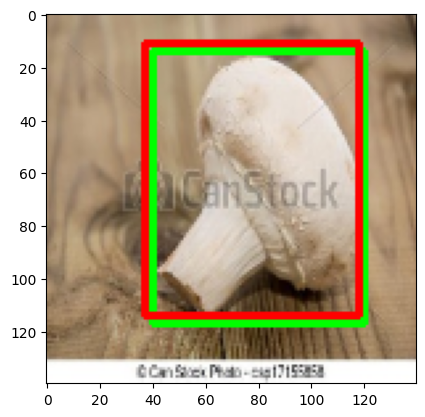

In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

with torch.no_grad():
  image , gt_bbox = validset[23] #(c,h,w)
  image = image.unsqueeze(0).to(DEVICE) #(bs,c,h,w)
  out_bbox = model(image)

  utils.compare_plots(image, gt_bbox, out_bbox)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya